In [8]:
import librosa
import os
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
#from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import csv
import torch.optim as optim
from tqdm import tqdm
#import feature_extraction.py

In [7]:
# loading processed_data.pkl from the google drive
 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# it takes forever to upload processed_data.pkl (1.3GB) through this method

#from google.colab import files
#files.upload()

In [191]:
agg_type = 'numerical'
feature = 'Extraversion' # Extraversion, Agreeableness, Conscientiousness, Neuroticism, Openness

batch_size = 16
lr = 2e-3
epochs=2


# New Section

In [192]:
#!pip3 install pickle5
import pickle5 as pickle

In [216]:
agg_type = 'numerical'
if agg_type == 'numerical':
    agg = ''
else:
    agg = '_categorical'

# path of processed_data.pkl
# to be updated depending on where the pkl file has been stored
pkl_path = '/content/drive/MyDrive/Colab Notebooks/processed_data.pkl'

with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

In [217]:
data.head()

,Clip_ID,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,Speaker_ID,Gender,Status,features
0,cut_feb1601-guest-0-2,1.727273,-1.363636,1.545455,1.545455,0.727273,92,M,J,"[[[0.00027620237, 0.0016822875, 0.001016233, 0..."
1,cut_feb1601-guest-2-10,0.727273,1.181818,1.909091,-1.727273,0.909091,183,M,J,"[[[0.38929665, 0.1189508, 0.0048722113, 0.0018..."
2,cut_feb1601-human-6,2.363636,-0.636364,1.363636,-0.545455,0.363636,41,M,G,"[[[0.7792231, 0.29407483, 0.03487174, 0.013430..."
3,cut_feb1602-guest-1-5,1.272727,0.636364,1.818182,-0.454545,0.000000,3,M,J,"[[[0.10963277, 0.097696155, 0.021039095, 0.024..."
4,cut_feb1602-guest-3-17,1.363636,-0.909091,2.181818,0.909091,0.636364,123,M,J,"[[[0.077622935, 0.14913885, 0.04175023, 0.0176..."


In [195]:
if agg_type=='numerical':
    cutoff = 0
    data['Extraversion'] = np.where(data['Extraversion'] > cutoff,1,0)
    data['Agreeableness'] = np.where(data['Agreeableness'] > cutoff,1,0)
    data['Conscientiousness'] = np.where(data['Conscientiousness'] > cutoff,1,0)
    data['Neuroticism'] = np.where(data['Neuroticism'] > cutoff,1,0)
    data['Openness'] = np.where(data['Openness'] > cutoff,1,0)


In [196]:
data.head()

,Clip_ID,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,Speaker_ID,Gender,Status,features
0,cut_feb1601-guest-0-2,1,0,1,1,1,92,M,J,"[[[0.00027620237, 0.0016822875, 0.001016233, 0..."
1,cut_feb1601-guest-2-10,1,1,1,0,1,183,M,J,"[[[0.38929665, 0.1189508, 0.0048722113, 0.0018..."
2,cut_feb1601-human-6,1,0,1,0,1,41,M,G,"[[[0.7792231, 0.29407483, 0.03487174, 0.013430..."
3,cut_feb1602-guest-1-5,1,1,1,0,0,3,M,J,"[[[0.10963277, 0.097696155, 0.021039095, 0.024..."
4,cut_feb1602-guest-3-17,1,0,1,1,1,123,M,J,"[[[0.077622935, 0.14913885, 0.04175023, 0.0176..."


In [197]:
#Split dataframe into train, validation, and test sets
train, val, test = np.split(data.sample(frac=1, random_state=101),
[int(.7*len(data)), int(.85*len(data))])

In [198]:
type(data['features'].iloc[0])

numpy.ndarray

In [199]:
train['features'].iloc[5].shape

(5, 128, 862)

In [200]:
class LibriSamples(torch.utils.data.Dataset):
    #Partition: the dataframe
    def __init__(self, dataframe, test_order=None, trait=None):
        #self.train=train

        #The personality trait for this run through
        self.trait = trait
        self.dataframe = dataframe
        #self.partition = partition

    def __len__(self):
        return len(self.dataframe.index)
    

    def __getitem__(self, ind):
        #X = np.load(self.dataframe['features'].iloc[ind])
        X = self.dataframe['features'].iloc[ind]
        
        """
        
        print(len(X))
        print(X[0].shape)
        print(X[1].shape)
        print(X[2].shape)
        print(X[3].shape)
        print(X[4].shape)
        
        t1 = [X[0], X[1]]

        X_trial = np.array(t1)
        
        print(f"trail check: {X_trial}")
        print(X_trial.shape)
        
        """
        
        X_arr = np.array(X)
        #print(X_arr.shape)
        X = torch.Tensor(X_arr)
        #X.reshape((1, X.shape[0], X.shape[1]))
        #print(X.shape)
        #Must transpose X so the the first value is length of audio and second value is number of features
        X = X.T # Already a tensor. if not X=torch.Tensor(X)
        X = torch.Tensor(X)
        #X = X.unsqueeze(0) # I am expecting it to be of shape (1, T, 128) # JUST CHECK if it (1, T, 128) or (1, 128, T)
        #X = torch.transpose(X,1,2)
        #if self.train:
        #Y = np.array(self.dataframe[self.trait].iloc[ind])
        Y = torch.from_numpy(np.array([self.dataframe[self.trait].iloc[ind]])).type(torch.Tensor)
        #if self.train:
        return X, Y
        #else:
        #return X


    def collate_fn(batch):
        batch_x = [x[1::] for x,y in batch]
        batch_y = [y for x,y in batch]

        batch_x_pad = pad_sequence(batch_x, batch_first=True) # batch_size, 1, T(max time dimension in the batch), 128

        lengths_x = [x.shape[0] for x in batch_x]

        #The y's should only have a length of 1, but we'll pad it anyway

        batch_y_pad = pad_sequence(batch_y, batch_first=True)
        #lengths_y = [y.shape[0] for y in batch_y]
        lengths_y = [y.shape[0] for y in batch_y]

        return batch_x_pad, batch_y_pad, torch.Tensor(lengths_x), torch.Tensor(lengths_y)


In [201]:
train_data = LibriSamples(train, trait=feature)
val_data = LibriSamples(val, trait=feature)
test_data = LibriSamples(test, trait=feature)

In [202]:
print(len(train_data))

448


In [203]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, collate_fn = LibriSamples.collate_fn)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle=False, collate_fn = LibriSamples.collate_fn) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False, collate_fn = LibriSamples.collate_fn) 

print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  16
Train dataset samples = 448, batches = 28
Val dataset samples = 96, batches = 6
Test dataset samples = 96, batches = 6


In [204]:
for data in val_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

for data in test_loader:
    x,y,lx,ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([16, 861, 128, 5]) torch.Size([16, 1]) torch.Size([16]) torch.Size([16])
torch.Size([16, 861, 128, 5]) torch.Size([16, 1]) torch.Size([16]) torch.Size([16])


In [205]:
import pdb

In [206]:
class Network(nn.Module):

    def __init__(self): # You can add any extra arguments as you wish

        super(Network, self).__init__()
        
        self.lstm = nn.LSTM(input_size=256, hidden_size = 256, num_layers=4, dropout=.1, bidirectional=True, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=128, kernel_size=3, stride=1, padding=1), # ADDED THIS 
            nn.BatchNorm2d(128),
            nn.GELU()
        )
        # YOU CAN ADD MORE CNN LAYERS HERE 
        self.classification = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                            nn.Flatten(),
                                            nn.Linear(128,1))
        # self.classification_1 = nn.Sequential(
        #     nn.Linear(in_features=512, out_features=1024),
        #     nn.Linear(in_features=1024, out_features=256),
        #     nn.Linear(in_features=256, out_features=1)
        # )

        # self.classification_2 = nn.Sequential(
        #     nn.Linear(in_features=430, out_features=1)
        # )
            

    def forward(self, x): 
        # print("forward1", x.shape)
        # out = torch.transpose(x, 1, 2) # B, T, 128 -> B, 128, T
        # print("forward2", out.shape)
        # out = self.cnn(out)
        # print("forward3", out.shape)
        # out = torch.transpose(out, 1, 2) # B, T, 256
        # print("forward4", out.shape)
        
        # packed_input = pack_padded_sequence(out, x_lengths, enforce_sorted=False, batch_first=True)
        # print("forward5")
        # out, (_, _) = self.lstm(packed_input)
        # print("forward6")
        # out, lengths  = pad_packed_sequence(out, batch_first=True)
        # print(out.shape)

        # out = self.classification_1(out)
        # out = torch.squeeze(out)
        # print(out.shape)
        # out = self.classification_2(out)

###############################################################################################################

        # X shape is batch_size, 1, T(max time dimension in the batch), 128

        # packed_input = pack_padded_sequence(x,x_length, batch_first = True, enforce_sorted=False)

        
        #packed_input = pack_padded_sequence(x,length.clamp(max=max_expected_len), batch_first = True, enforce_sorted=False)
        #pdb.set_trace()
        # out1, (out2, out3) =  self.lstm(packed_input) 
        
        x = x.transpose(1, 3)
        
        #print(f"x shape: {x.shape}")
        
        
        
        out = self.cnn(x) # batch_size, 64, T_reduced, 128_reduced
        # DO AVERAGE POOLING, WE EXPECT IS OF THE SHAPE (batchsize, feature_dim)

        # As you may see from the LSTM docs, LSTM returns 3 vectors. Which one do you need to pass to the next function?
        # out, lengths  = pad_packed_sequence(out1, batch_first=True) 
        #pdb.set_trace()
        #pdb.set_trace()
        out = self.classification(out)  # classification (feature_dim, num_classes) (2)
        
        #Is dimension 2 or 3? Or something else?
   
        # m = nn.LogSoftmax(dim=1) # Optional: Do log softmax on the output. Which dimension?
        #out = F.log_softmax(out,dim=1) # CHANGED THE DIM to 1
        out = torch.sigmoid(out)
        return out #lengths 

#model = Network().to(device)

In [207]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Network().to(device)
print(model)

Network(
  (lstm): LSTM(256, 256, num_layers=4, batch_first=True, dropout=0.1, bidirectional=True)
  (cnn): Sequential(
    (0): Conv2d(5, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
  )
  (classification): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [208]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .002)
#scaler = torch.cuda.amp.GradScaler()


In [209]:
epochs=40


In [210]:
import torch
torch.cuda.empty_cache()


In [211]:
train_acc_list = list()
train_loss_list = list()
lr_list = list()
validation_acc_list = list()

print('train_loader: ', len(train_loader))

for epoch in range(epochs):

    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    model.train()
    total_loss = 0
    num_correct=0

    for i, data in enumerate(train_loader,0):
        
             

        x = data[0].to(device)
        x = x.unsqueeze(1)
        y = data[1].to(device)
        #print('y: ', y)
        # x_lengths = data[2]
        
        x = torch.squeeze(x)

        
        output=model(x)
        #print('output: ', output)
        #print('y: ,', y)

        # y = y.type(torch.FloatTensor).to(device)
        loss = criterion(output, y)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        

        prediction_out = (output>0.5).float()

        """
        print(f"output: {output}")
        print(f"prediction_out: {prediction_out}")
        print(f"y: {y} \tprediction_out==y: {prediction_out==y}")
        """
        
        num_correct += int((prediction_out==y).sum())
        total_loss += loss
        batch_bar.set_postfix(
          loss="{:.04f}".format(float(total_loss/(i+1)))
        )

        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
    

        batch_bar.update()

    #print('training num correct: ,', num_correct)

    batch_bar.close()
    val_num_correct = 0
    for i, data in enumerate(val_loader):
        optimizer.zero_grad()
        x = data[0].to(device)
        x = x.unsqueeze(1)
        y = data[1].to(device)
        
        x = torch.squeeze(x)
        
        #with torch.cuda.amp.autocast():
        val_outputs = model(x)
        
        prediction_val = (val_outputs>0.5).float()
        val_num_correct += int((prediction_val==y).sum())
        #val_num_correct += int((torch.argmax(val_outputs,axis=0)==y).sum())
        
        """
        print(f"val_outputs: {val_outputs}")
        print(f"prediction_val: {prediction_val}")
        print(f"y: {y} \tprediction_val==y: {prediction_val==y}")
        """
        
    train_acc = 100 * num_correct / (len(train_loader) * batch_size)
    train_loss = float(total_loss / len(train_loader))
    lr = float(optimizer.param_groups[0]['lr'])
    validation_acc = 100 * val_num_correct / (len(val_loader)*batch_size)


    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    lr_list.append(lr)
    validation_acc_list.append(validation_acc)


    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {:.04f}, Learning Rate {:.04f}, Val Acc {:.04f}%".format(
        epoch + 1,
        epochs,
        100 * num_correct / (len(train_loader) * batch_size),
        float(total_loss / len(train_loader)),
        float(optimizer.param_groups[0]['lr']),
        100 * val_num_correct / (len(val_loader)*batch_size)))

    
    #print(train_acc_list, validation_acc_list, train_loss_list, lr_list)

train_loader:  28


Epoch 1/40: Train Acc 58.0357%, Train Loss 0.6776, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 2/40: Train Acc 62.2768%, Train Loss 0.6612, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 3/40: Train Acc 62.2768%, Train Loss 0.6601, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 4/40: Train Acc 62.2768%, Train Loss 0.6602, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 5/40: Train Acc 62.2768%, Train Loss 0.6595, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 6/40: Train Acc 62.2768%, Train Loss 0.6595, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 7/40: Train Acc 62.2768%, Train Loss 0.6621, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 8/40: Train Acc 62.2768%, Train Loss 0.6606, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 9/40: Train Acc 62.2768%, Train Loss 0.6577, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 10/40: Train Acc 62.2768%, Train Loss 0.6618, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 11/40: Train Acc 62.2768%, Train Loss 0.6602, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 12/40: Train Acc 62.2768%, Train Loss 0.6595, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 13/40: Train Acc 62.2768%, Train Loss 0.6591, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 14/40: Train Acc 62.2768%, Train Loss 0.6600, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 15/40: Train Acc 62.2768%, Train Loss 0.6597, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 16/40: Train Acc 62.2768%, Train Loss 0.6594, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 17/40: Train Acc 62.2768%, Train Loss 0.6619, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 18/40: Train Acc 62.2768%, Train Loss 0.6589, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 19/40: Train Acc 62.2768%, Train Loss 0.6576, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 20/40: Train Acc 62.2768%, Train Loss 0.6583, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 21/40: Train Acc 62.2768%, Train Loss 0.6577, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 22/40: Train Acc 62.2768%, Train Loss 0.6576, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 23/40: Train Acc 62.2768%, Train Loss 0.6585, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 24/40: Train Acc 62.2768%, Train Loss 0.6563, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 25/40: Train Acc 62.2768%, Train Loss 0.6560, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 26/40: Train Acc 62.2768%, Train Loss 0.6573, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 27/40: Train Acc 62.2768%, Train Loss 0.6584, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 28/40: Train Acc 62.2768%, Train Loss 0.6582, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 29/40: Train Acc 62.2768%, Train Loss 0.6600, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 30/40: Train Acc 62.2768%, Train Loss 0.6603, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 31/40: Train Acc 62.2768%, Train Loss 0.6580, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 32/40: Train Acc 62.2768%, Train Loss 0.6562, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 33/40: Train Acc 62.2768%, Train Loss 0.6566, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 34/40: Train Acc 62.2768%, Train Loss 0.6560, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 35/40: Train Acc 62.2768%, Train Loss 0.6574, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 36/40: Train Acc 62.2768%, Train Loss 0.6570, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 37/40: Train Acc 62.2768%, Train Loss 0.6563, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 38/40: Train Acc 62.2768%, Train Loss 0.6569, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 39/40: Train Acc 62.2768%, Train Loss 0.6563, Learning Rate 0.0020, Val Acc 70.8333%


Epoch 40/40: Train Acc 62.2768%, Train Loss 0.6534, Learning Rate 0.0020, Val Acc 70.8333%


In [212]:
train_acc_arr = np.array(train_acc_list)
val_acc_arr = np.array(validation_acc_list)
train_loss_arr = np.array(train_loss_list)
lr_arr = np.array(lr_list)

results_df = pd.DataFrame({'epoch_number': np.arange(40),
                      'train_accuracy': train_acc_arr,
                      'validation_accuracy': val_acc_arr,
                      'train_loss': train_loss_arr,
                      'learning_rate': lr_arr})

results_df.to_csv(str(feature) + '_results.csv', index=False)

In [213]:
#To import the results from a local csv file of previous run

Extraversion_results_df = pd.read_csv("Extraversion_results.csv", header = 0)

Agreeableness_results_df = pd.read_csv("Agreeableness_results.csv", header = 0)

Conscientiousness_results_df = pd.read_csv("Conscientiousness_results.csv", header = 0)

Neuroticism_results_df = pd.read_csv("Neuroticism_results.csv", header = 0)

Openness_results_df = pd.read_csv("Openness_results.csv", header = 0)


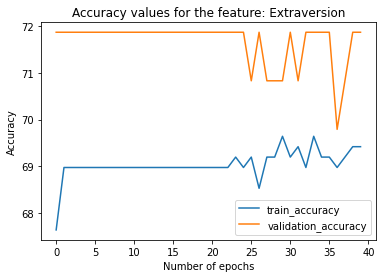

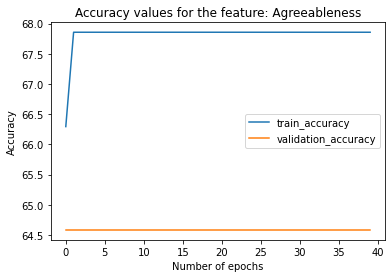

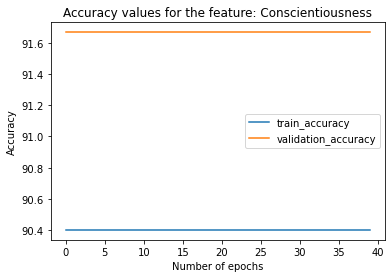

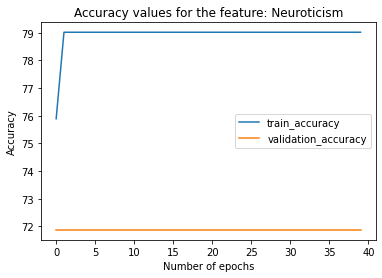

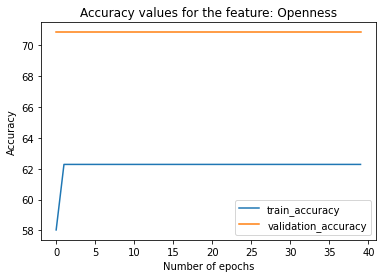

In [215]:
import matplotlib.pyplot as plt

feat_list = ["Extraversion", 
             "Agreeableness",
             "Conscientiousness",
             "Neuroticism",
             "Openness"]

results_df_list = [Extraversion_results_df,
                   Agreeableness_results_df,
                   Conscientiousness_results_df,
                   Neuroticism_results_df,
                   Openness_results_df]


for feat, results_df in zip(feat_list, results_df_list):
    
    plt.plot(results_df['train_accuracy'], label="train_accuracy")
    plt.plot(results_df['validation_accuracy'], label="validation_accuracy")
    plt.title('Accuracy values for the feature: ' + str(feat))
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.legend()
    plt.show()